# Descripción del proyecto

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

# Leer datos

In [6]:
#importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [7]:
# Leer dataframe
df_games = pd.read_csv('df_games.csv')

In [8]:
# Revisar los datos

df_games.info()

df_games.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
7104,Spec Ops: The Line,PC,2012.0,Shooter,0.11,0.09,0.00,0.02,76.0,8.2,M
5910,Power Pro Kun Pocket 6,GBA,2003.0,Sports,0.00,0.00,0.29,0.01,NaN,NaN,NaN
8063,The Last Airbender,DS,2010.0,Action,0.13,0.04,0.00,0.01,69.0,7,E10+
15622,Rugby 06,XB,2006.0,Sports,0.01,0.00,0.00,0.00,76.0,tbd,NaN
2594,WCW Mayhem,N64,1999.0,Fighting,0.63,0.15,0.00,0.01,NaN,NaN,NaN


# Preparar los datos

In [9]:
# Reemplaza los nombres de las columnas.


df_games.columns = [x.lower() for x in df_games.columns]

df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
# Convertir los datos en los tipos necesarios.

# Columna year_of_release a entero 

df_games['year_of_release'] = df_games['year_of_release'].fillna(0)

df_games['year_of_release'] = df_games['year_of_release'].astype(int)

# Columna critic_score a entero (Ya que no hay valores con decimales)

df_games['critic_score'] = df_games['critic_score'].fillna(0)

df_games['critic_score'] = df_games['critic_score'].astype(int)

# Columna user_score a flotante y cambio de tbd (to be determinated) por 0

df_games.loc[df_games['user_score'] == 'tbd', 'user_score'] = 0

df_games['user_score'] = df_games['user_score'].fillna(0)

df_games["user_score"] = df_games['user_score'].astype(float)

df_games['user_score'] = df_games['user_score']*10

In [11]:
#Numero de juegos donde no hay año

no_year = df_games[df_games['year_of_release']==0]
no_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 183 to 16522
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             269 non-null    object 
 1   platform         269 non-null    object 
 2   year_of_release  269 non-null    int64  
 3   genre            269 non-null    object 
 4   na_sales         269 non-null    float64
 5   eu_sales         269 non-null    float64
 6   jp_sales         269 non-null    float64
 7   other_sales      269 non-null    float64
 8   critic_score     269 non-null    int64  
 9   user_score       269 non-null    float64
 10  rating           181 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 25.2+ KB


In [12]:
#rellenar el año de los juegos que no lo tienen con el que tienen esos mismos juegos en otra plataforma

for i, row in no_year.iterrows():
    game = df_games[(df_games['name'] == row['name']) & (df_games['year_of_release'].notnull())]
    
    if not game.empty: 
        proxy_year = game['year_of_release'].iloc[0]
        df_games.loc[i,'year_of_release'] = proxy_year
        
print(df_games[df_games['year_of_release']==0].info())

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 183 to 16522
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             191 non-null    object 
 1   platform         191 non-null    object 
 2   year_of_release  191 non-null    int64  
 3   genre            191 non-null    object 
 4   na_sales         191 non-null    float64
 5   eu_sales         191 non-null    float64
 6   jp_sales         191 non-null    float64
 7   other_sales      191 non-null    float64
 8   critic_score     191 non-null    int64  
 9   user_score       191 non-null    float64
 10  rating           123 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 17.9+ KB
None


In [13]:
# Muestra del dataframe
df_games.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2710,Mario & Luigi: Paper Jam,3DS,2015,Role-Playing,0.16,0.29,0.26,0.04,0,0.0,NaN
14131,Sangoku Koi Senki: Otome no Heihou!,PSP,2012,Adventure,0.00,0.00,0.04,0.00,0,0.0,NaN
15519,Ro-Kyu-Bu! Lost Secret,PSP,2013,Adventure,0.00,0.00,0.02,0.00,0,0.0,NaN
12853,Tokyo Mono Harashi: Karasu no Mori Gakuen Kitan,PSP,2010,Role-Playing,0.00,0.00,0.06,0.00,0,0.0,NaN
4202,Godzilla: Save the Earth,PS2,2004,Fighting,0.23,0.18,0.00,0.06,62,87.0,T
3913,Naruto Shippuden: Clash of Ninja Revolution 3,Wii,2009,Fighting,0.44,0.03,0.00,0.04,74,81.0,T
7528,"Warhammer 40,000: Space Marine",PC,2011,Shooter,0.09,0.09,0.00,0.03,74,74.0,M
15018,The Idolmaster: Gravure For You! Vol.7,PS3,2012,Action,0.00,0.00,0.02,0.00,0,0.0,NaN
6362,Superbike 2000,PS,1999,Racing,0.15,0.10,0.00,0.02,0,0.0,NaN
3181,NBA Live 08,PS3,2007,Sports,0.56,0.02,0.01,0.05,73,68.0,E



* Converti la columna year of release a entero por que se trata de años, los valores ausentes los converti en 0 (significa que no se tiene la informacion)

* La columna critic score la converti a entero para trabajar con operaciones de una manera mas comoda, los valores ausentes los converti en 0 para no tener errores con las operaciones (en este caso estoy considerando el puntaje mas bajo para un juego no calificado)

* La columna user score la multiplique por 10  y la converti a tipo flotante, de igual manera los valores ausentes los converti a 0 considerandolo como el puntaje mas bajo

In [14]:
#identificar duplicados por nombre y plataforma

df_games[df_games[['name','platform']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83,85.0,T
4127,Sonic the Hedgehog,PS3,1991,Platform,0.0,0.48,0.00,0.00,43,41.0,E10+
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82,85.0,T
14244,NaN,GEN,1993,NaN,0.0,0.00,0.03,0.00,0,0.0,NaN
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83,55.0,E


In [15]:
#Eliminar los duplicados
df_games = df_games.drop([1591,11715,14244,16230]).reset_index(drop = True)

In [16]:
#reemplazar casos donde nombre es nan por not defined

df_games.loc[df_games['name'].isna(),'name'] = 'NOT DEFINED'

In [17]:
#reemplazar casos donde nombre es nan por not defined
df_games['genre'] = df_games['genre'].fillna('NOT DEFINED')

In [18]:
#Calcula las ventas totales (la suma de las ventas en todas las regiones) para cada juego y coloca estos valores en una columna separada.

df_games['total_sales'] = df_games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
df_games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2509,Killer Instinct Gold,N64,1996,Fighting,0.61,0.19,0.00,0.01,0,0.0,NaN,0.81
9664,SCORE International Baja 1000: The Official Game,X360,2008,Racing,0.11,0.01,0.00,0.01,0,0.0,NaN,0.13
15907,The Incredibles: Rise of the Underminer,PC,2005,Action,0.01,0.00,0.00,0.00,65,0.0,E10+,0.01
4339,Pirates of the Caribbean: At World's End,Wii,2007,Action,0.39,0.02,0.01,0.04,53,72.0,T,0.46
12026,Zettai Zetsumei Toshi 3: Kowareyuku Machi to K...,PSP,2009,Action,0.00,0.00,0.07,0.00,0,0.0,NaN,0.07


# Analiza los datos

In [19]:
# Observar cuántos juegos fueron lanzados en diferentes años.

diff_year = df_games['year_of_release'].value_counts().sort_index()

print(diff_year)

year_of_release
0        191
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      42
1992      43
1993      61
1994     121
1995     219
1996     263
1997     289
1998     380
1999     339
2000     351
2001     486
2002     837
2003     779
2004     764
2005     941
2006    1013
2007    1201
2008    1440
2009    1429
2010    1263
2011    1148
2012     653
2013     548
2014     581
2015     606
2016     502
Name: count, dtype: int64


Se puede observar que antes de 1994 la cantidad de juegos lanzados no superaba las 2 cifras, y tambien que el periodo donde las cifras son las mas altas fue de 2002 al 2011 y a partir del año 2012 se estandarizo el numero entre 500 y 700

platform
PS2     1255.77
X360     970.17
PS3      939.64
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.44
Name: total_sales, dtype: float64


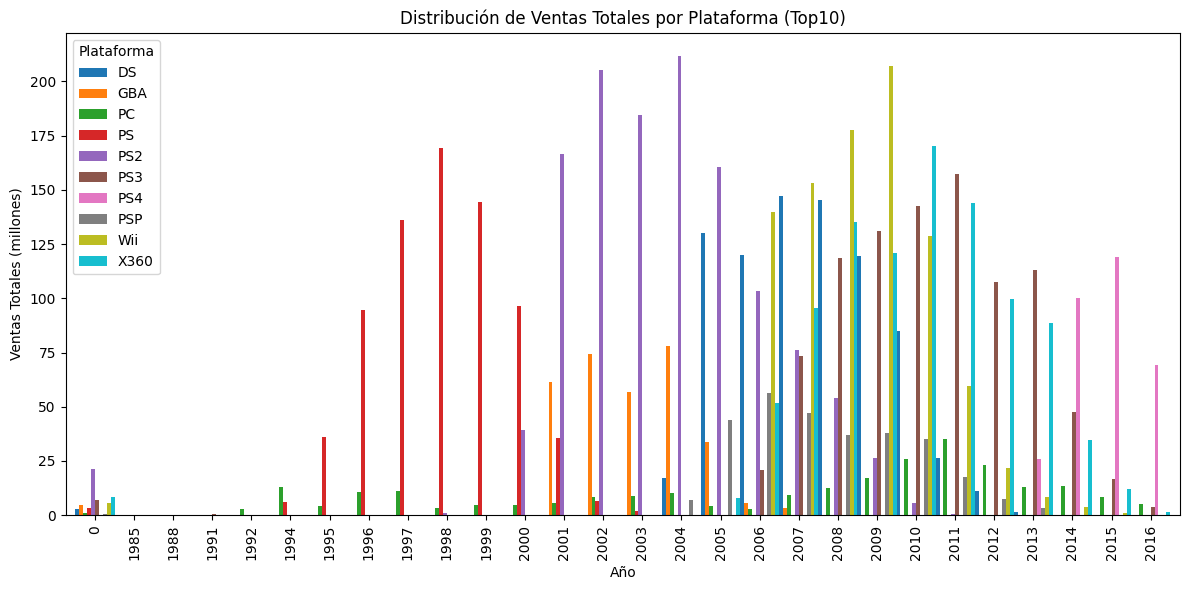

In [20]:
#Observar cómo varían las ventas de una plataforma a otra.
#Elegir las plataformas con las mayores ventas totales y construir una distribución basada en los datos de cada año. 

diff_platform = df_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

print(diff_platform.head(10))

top_platforms = diff_platform.head(10).index

df_top_platforms = df_games[df_games['platform'].isin(top_platforms)]

ventas_anuales = df_top_platforms.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

ventas_anuales.plot(kind='bar', figsize=(12, 6), stacked=False, width=1)
plt.title('Distribución de Ventas Totales por Plataforma (Top10)')
plt.xlabel('Año')
plt.ylabel('Ventas Totales (millones)')
plt.legend(title='Plataforma')
plt.tight_layout()
plt.show()

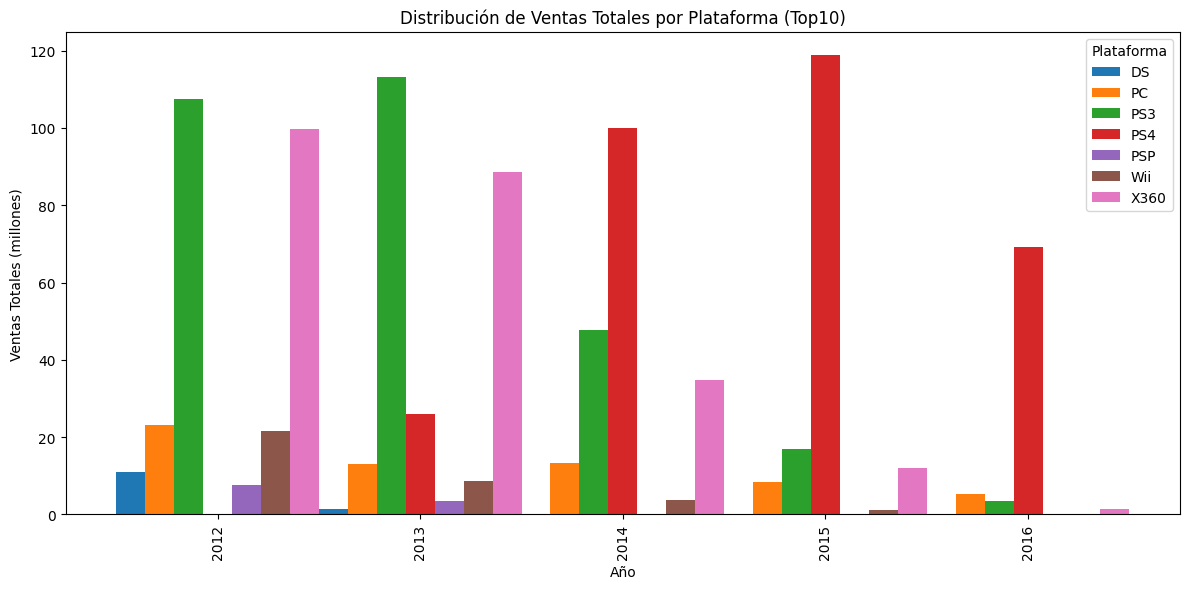

In [21]:
#Analisis de los ultimos 5 años
near_years = df_top_platforms[df_top_platforms['year_of_release'] >= 2012]

ventas_anuales = near_years.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

ventas_anuales.plot(kind='bar', figsize=(12, 6), stacked=False, width=1)
plt.title('Distribución de Ventas Totales por Plataforma (Top10)')
plt.xlabel('Año')
plt.ylabel('Ventas Totales (millones)')
plt.legend(title='Plataforma')
plt.tight_layout()
plt.show()

# Plataformas que solían ser populares pero que ahora no tienen ventas. 

El play station tuvo popularidad los 5 primeros años pero sus ventas terminaron luego de 10 años
A pesar de ser la plataforma con mas ventas, el play station 2 tuvo sus ultimas ventas en 2011, durando 11 años en el mercado
El play station 3 tuvo ventas desde el 2006 y hasta 2016
El ps4 inicio sus ventas en el 2013
El nintendo DS tuvo sus ultimas ventas en 2012 y sus inicios fueron en 2004
El GBA tuvo una duracion de 2001 a 2007 .

# ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer? 

Tienen ventas de 6 a 10 años

# Determina para qué período debes tomar datos. Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.

Deberia tomar datos desde 5 años antes, es decir desde el 2012


# ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.

Play station es lider en ventas en sus 3 consolas, pudiera decir que con datos de años consiguientes tambien lo seria de el ps4

C:\Users\richi\AppData\Local\Temp\ipykernel_9552\2543783084.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='platform', y='total_sales', palette='Set3')


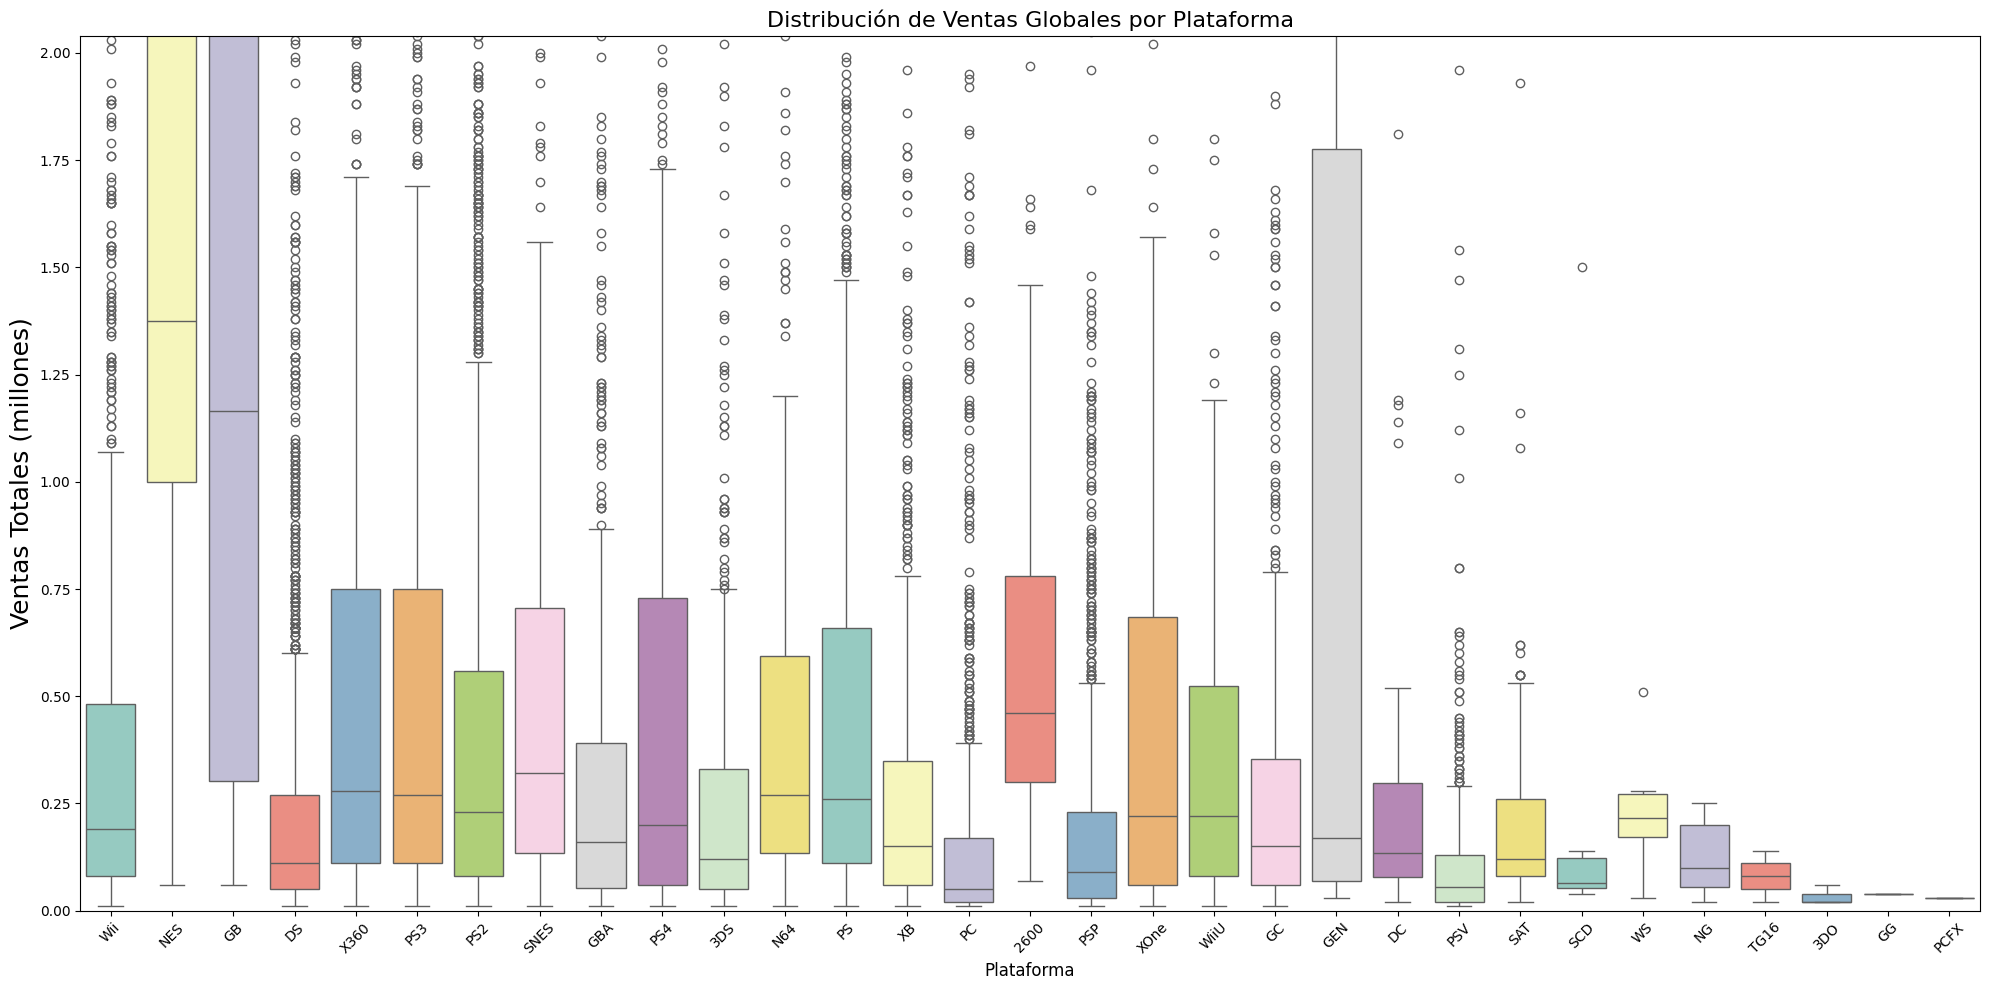

In [22]:
#Crear un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. 


filtered_df = df_games[df_games['total_sales'] > 0]

plt.figure(figsize=(20, 10))
sns.boxplot(data=filtered_df, x='platform', y='total_sales', palette='Set3')

plt.title('Distribución de Ventas Globales por Plataforma', fontsize=16)
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Ventas Totales (millones)', fontsize=18)
plt.xticks(rotation=45)
plt.ylim(0, filtered_df['total_sales'].quantile(0.95)) 

plt.tight_layout()
plt.show()


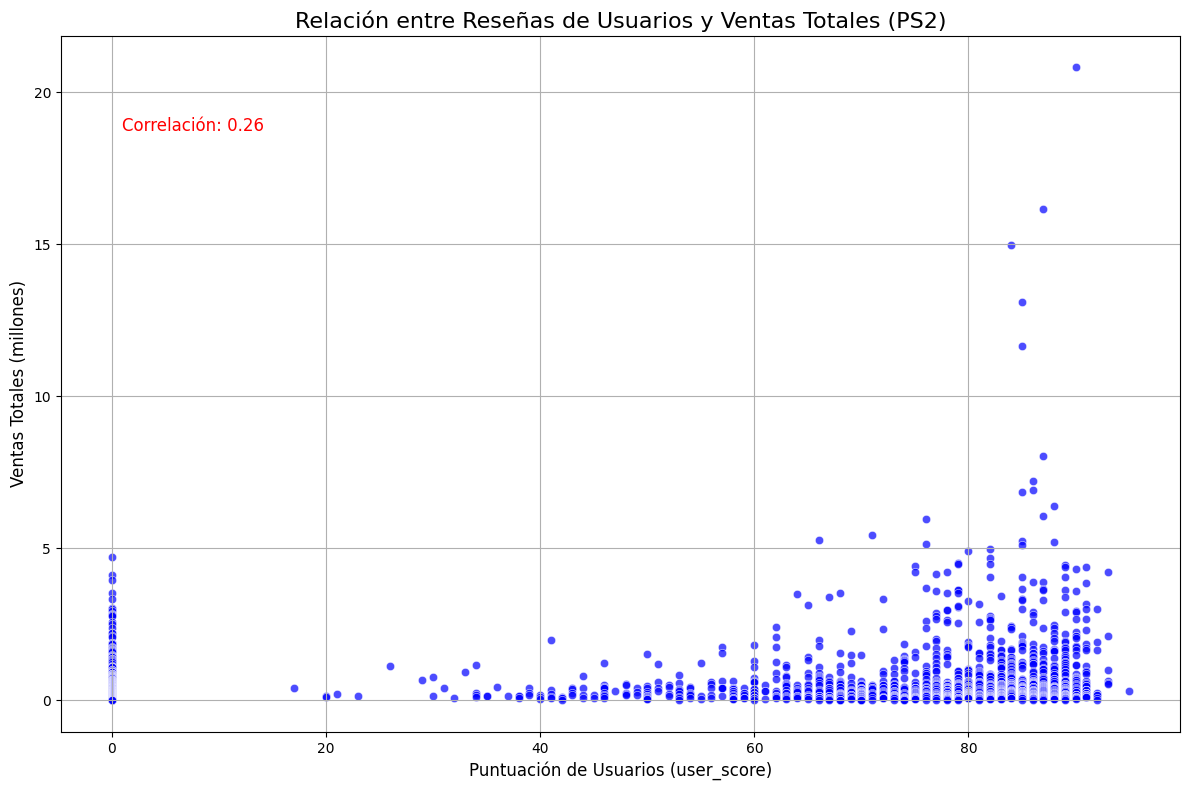

Correlación: 0.26


In [23]:
# Observar cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular. 
#Crear un gráfico de dispersión y calcular la correlación entre las reseñas y las ventas. 


platform_data = df_games[df_games['platform'] == 'PS2']
platform_data = platform_data.dropna(subset=['user_score', 'total_sales'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=platform_data, x='user_score', y='total_sales', alpha=0.7, color='blue')

plt.title('Relación entre Reseñas de Usuarios y Ventas Totales (PS2)', fontsize=16)
plt.xlabel('Puntuación de Usuarios (user_score)', fontsize=12)
plt.ylabel('Ventas Totales (millones)', fontsize=12)
plt.grid(True)


correlation, _= pearsonr(platform_data['user_score'], platform_data['total_sales'])

plt.text(1, max(platform_data['total_sales']) * 0.9, f'Correlación: {correlation:.2f}', fontsize=12, color='red')

plt.tight_layout()
plt.show()

print(f"Correlación: {correlation:.2f}")

# Conclusiones:

La correlación entre las reseñas de los usuarios y las ventas totales es muy baja, lo cual significa que no afectan a las ventas.

In [24]:
# Comparacion de las ventas de los mismos juegos en otras plataformas.

juegos_multiplataforma = df_games.groupby('name')['platform'].nunique()

juegos_multiplataforma = juegos_multiplataforma[juegos_multiplataforma > 1]

juegos_detalles = df_games[df_games['name'].isin(juegos_multiplataforma.index)]

print(juegos_detalles)

                                                   name platform  \
1                                     Super Mario Bros.      NES   
5                                                Tetris       GB   
16                                   Grand Theft Auto V      PS3   
17                        Grand Theft Auto: San Andreas      PS2   
18                                    Super Mario World     SNES   
...                                                 ...      ...   
16702                     Men in Black II: Alien Escape       GC   
16705  SCORE International Baja 1000: The Official Game      PS2   
16706                     Samurai Warriors: Sanada Maru      PS3   
16709                                  Spirits & Spells      GBA   
16710                               Winning Post 8 2016      PSV   

       year_of_release       genre  na_sales  eu_sales  jp_sales  other_sales  \
1                 1985    Platform     29.08      3.58      6.81         0.77   
5                 198

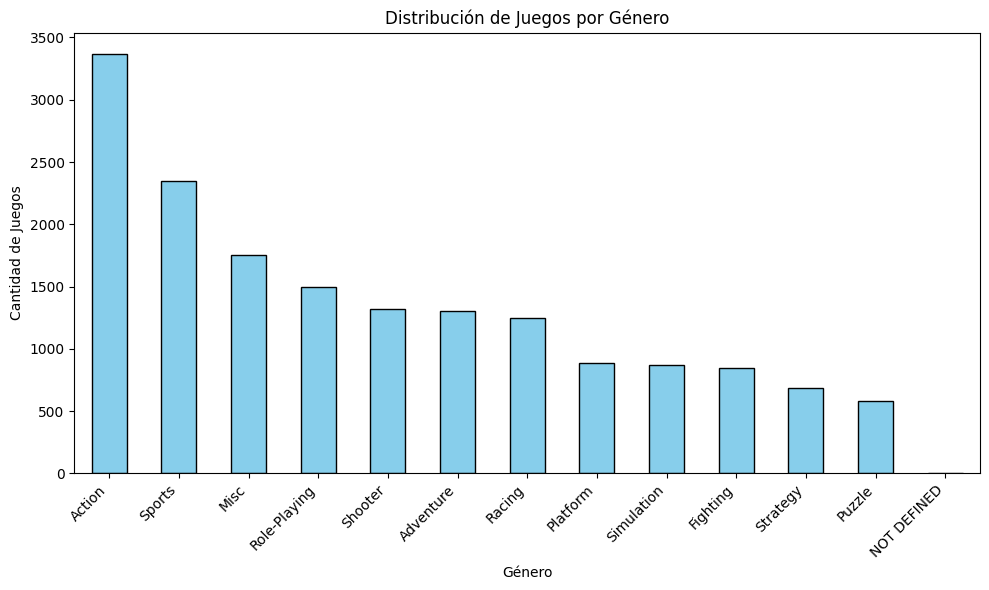

In [25]:
# Distribución general de los juegos por género.

game_genre = df_games.groupby('genre')['name'].count().sort_values(ascending=False)
game_genre.head()

plt.figure(figsize=(10, 6))
game_genre.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de Juegos por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

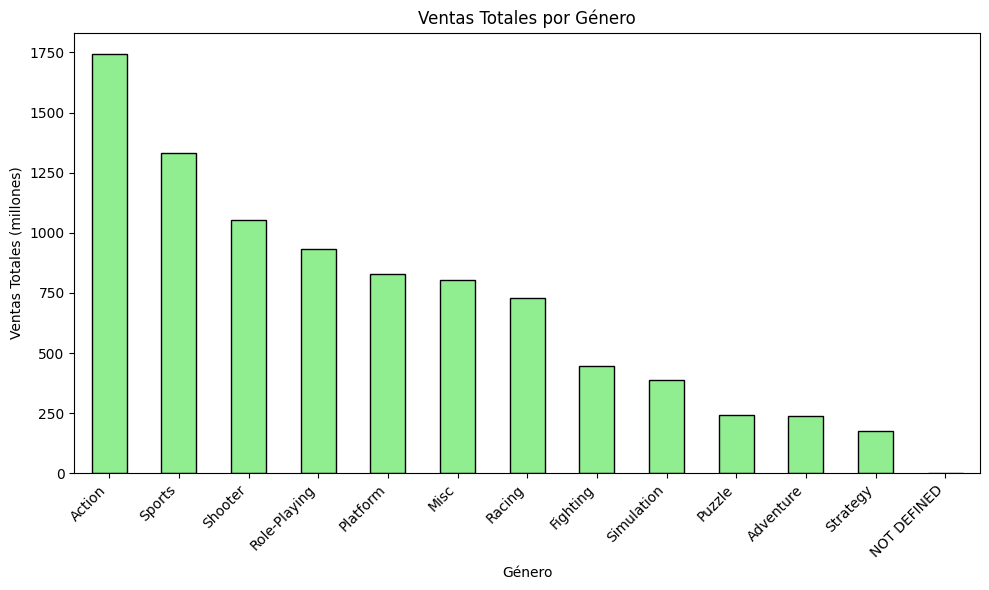

In [26]:
# ventas por genero

genre_sales = df_games.groupby('genre')['total_sales'].sum().sort_values(ascending=False)


# Graficar las ventas totales por género
plt.figure(figsize=(10, 6))
genre_sales .plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Ventas Totales por Género')
plt.xlabel('Género')
plt.ylabel('Ventas Totales (millones)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Géneros más rentables:

Existen mas de 3000 juegos de accion que han producido un valor cercano a 1750mdd y mas de 2000 juegos de deportes produjeron mas de 1250mdd

# Géneros con ventas altas y bajas:

En general los generos con ventas altas obtienen arriba de 1000 mdd y los de ventas bajas 250 mdd o menos

# Perfil de usuario para cada región

Top 5 plataformas en na_sales:
platform
X360    601.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64

Top 5 plataformas en eu_sales:
platform
PS2     339.29
PS3     330.28
X360    270.63
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64

Top 5 plataformas en jp_sales:
platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64



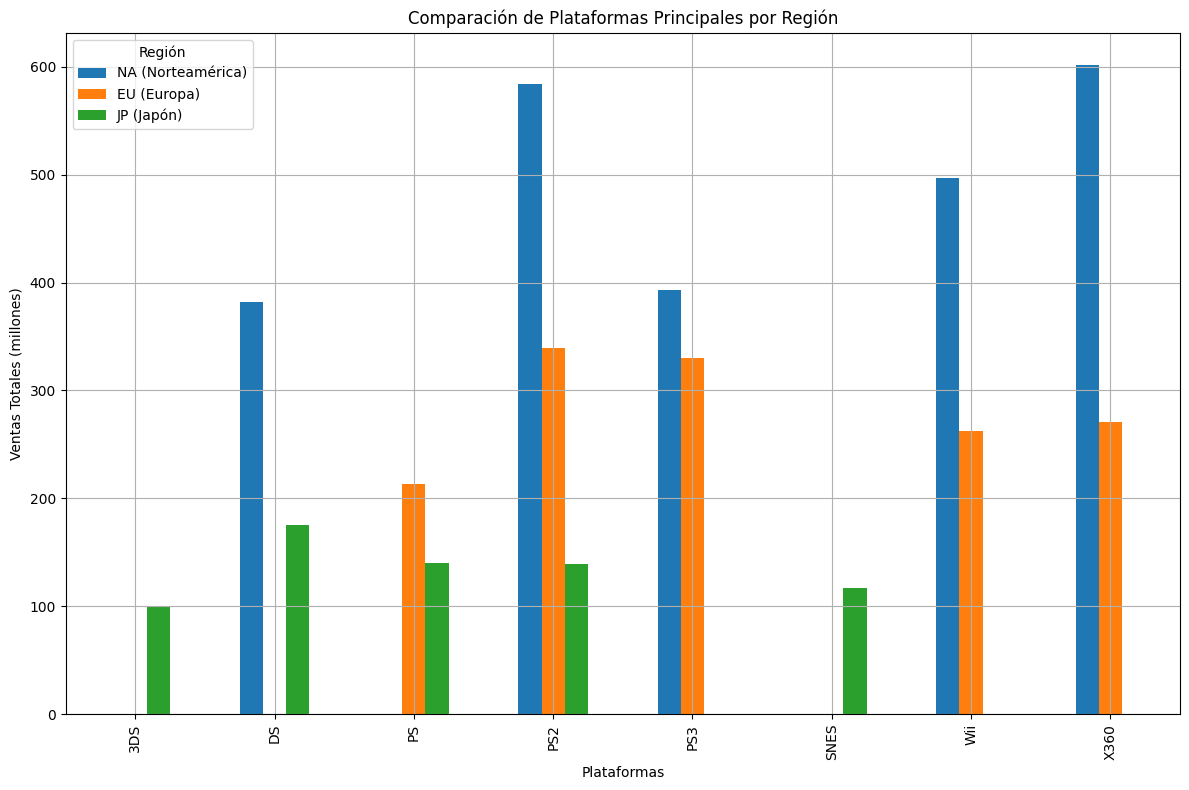

In [27]:
# Para cada región (NA, UE, JP) determinar:
#Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.

sales_regions = ['na_sales', 'eu_sales', 'jp_sales']

# Crear un diccionario para guardar los datos
region_top_platforms = {}

for region in sales_regions:
    top_platforms = (
        df_games.groupby('platform')[region]
        .sum()
        .sort_values(ascending=False)
        .head(5)  
    )
    region_top_platforms[region] = top_platforms

for region, platforms in region_top_platforms.items():
    print(f"Top 5 plataformas en {region}:\n{platforms}\n")


platforms_comparison = pd.DataFrame(region_top_platforms).fillna(0)
platforms_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de Plataformas Principales por Región')
plt.xlabel('Plataformas')
plt.ylabel('Ventas Totales (millones)')
plt.legend(['NA (Norteamérica)', 'EU (Europa)', 'JP (Japón)'], title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 5 géneros en na_sales:
genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64

Top 5 géneros en eu_sales:
genre
Action     519.13
Sports     376.78
Shooter    317.34
Racing     236.32
Misc       212.74
Name: eu_sales, dtype: float64

Top 5 géneros en jp_sales:
genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64



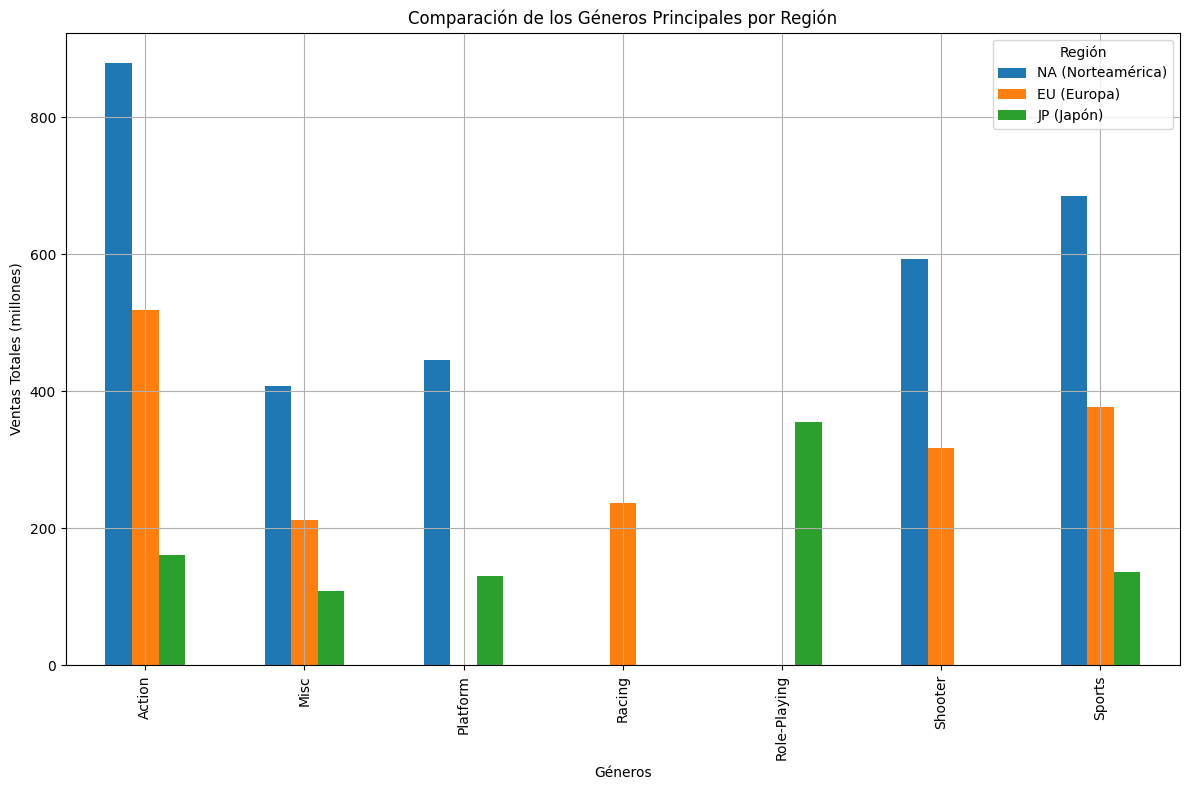

In [28]:
#Los cinco géneros principales.

sales_regions = ['na_sales', 'eu_sales', 'jp_sales']

region_top_genres = {}

for region in sales_regions:
    top_genres = (
        df_games.groupby('genre')[region]
        .sum()
        .sort_values(ascending=False)
        .head(5)  
    )
    region_top_genres[region] = top_genres

for region, genres in region_top_genres.items():
    print(f"Top 5 géneros en {region}:\n{genres}\n")

genres_comparison = pd.DataFrame(region_top_genres).fillna(0)
genres_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de los Géneros Principales por Región')
plt.xlabel('Géneros')
plt.ylabel('Ventas Totales (millones)')
plt.legend(['NA (Norteamérica)', 'EU (Europa)', 'JP (Japón)'], title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

 # Diferencias.
 
 Tanto en Norteamerica como en Europa el genero mas popular es el de accion, mientras que en Japon el mas popular es el juego de rol. 
 Como segundo lugar Na y Eu tienen el genero de deportes, y en Jp es el de accion.
 El role playing solo se juega en Japon, y el racing solo de juega en Europa.

Ventas por clasificación ESRB en na_sales:
rating
E       1292.99
T        758.75
M        748.48
E10+     353.32
K-A        2.56
EC         1.53
AO         1.26
RP         0.00
Name: na_sales, dtype: float64

Ventas por clasificación ESRB en eu_sales:
rating
E       710.24
M       483.97
T       426.84
E10+    188.52
AO        0.61
K-A       0.27
EC        0.11
RP        0.08
Name: eu_sales, dtype: float64

Ventas por clasificación ESRB en jp_sales:
rating
E       198.11
T       151.38
M        64.24
E10+     40.20
K-A       1.46
AO        0.00
EC        0.00
RP        0.00
Name: jp_sales, dtype: float64



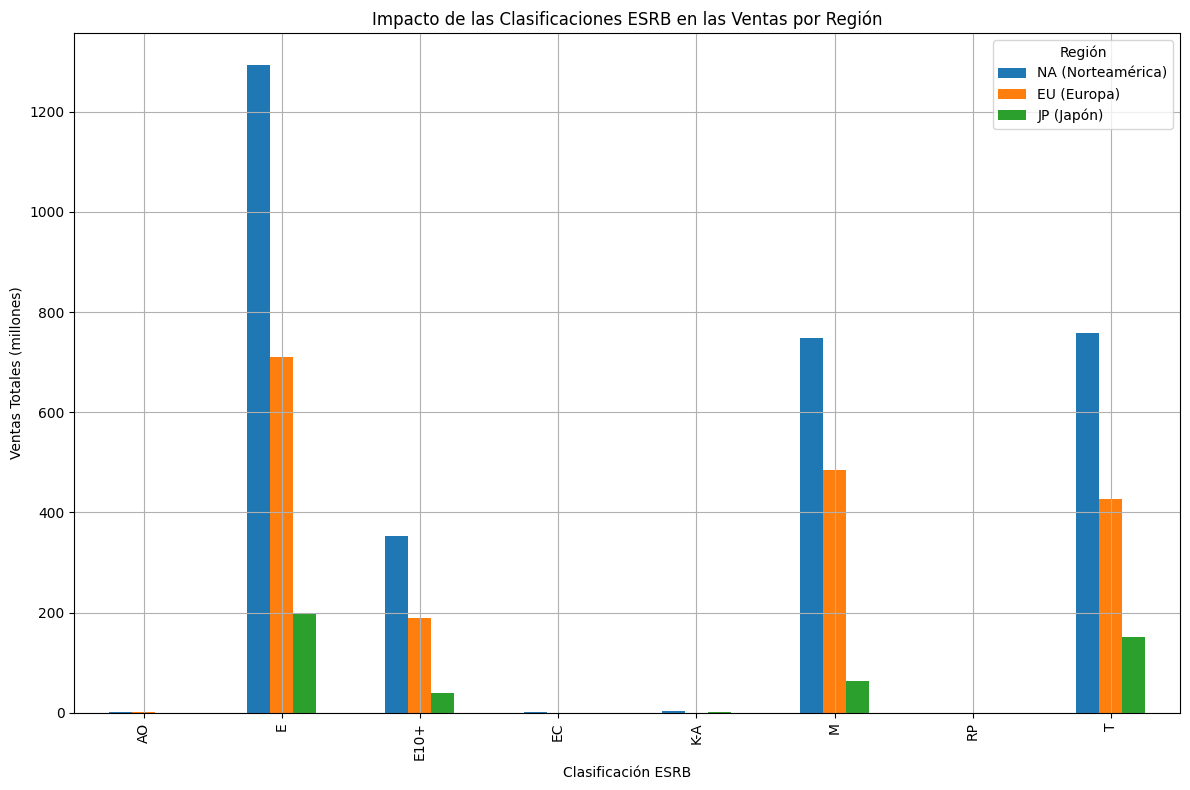

In [29]:
# Observar si clasificaciones de ESRB afectan a las ventas en regiones individuales.

esrb_sales_by_region = {}

for region in sales_regions:

    sales_by_esrb = (df_games.groupby('rating')[region].sum().sort_values(ascending=False))
    esrb_sales_by_region[region] = sales_by_esrb


for region, sales in esrb_sales_by_region.items():
    print(f"Ventas por clasificación ESRB en {region}:\n{sales}\n")

esrb_sales_comparison = pd.DataFrame(esrb_sales_by_region).fillna(0)


esrb_sales_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Impacto de las Clasificaciones ESRB en las Ventas por Región')
plt.xlabel('Clasificación ESRB')
plt.ylabel('Ventas Totales (millones)')
plt.legend(['NA (Norteamérica)', 'EU (Europa)', 'JP (Japón)'], title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

En todas las regiones la clasificacion Everyone es la preferida y la clasificacion pendiente es la menos jugada.

# Pruebas de Hipótesis:

In [30]:
#Hipotesis nula: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

#Hipotesis alternativa: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

xboxone = df_games[(df_games['platform'] == 'XOne') & (df_games['user_score'])]['user_score']

pc = df_games[(df_games['platform'] == 'PC') & (df_games['user_score'])]['user_score']

t_stat, p_value = ttest_ind(xboxone, pc)

print(f"Prueba t de Student: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: Las calificaciones promedio son diferentes.")
else:
    print("No se puede rechazar la hipótesis nula: Las calificaciones promedio son iguales.")


Prueba t de Student: t-statistic = -4.353, p-value = 0.000
Rechazamos la hipótesis nula: Las calificaciones promedio son diferentes.


La hipotesis nula es la instruccion que me dieron para comprobar el ejemplo, la alternativa es el caso contrario, mientras que el alfa de 0.05 es un valor estandar utilizado en pruebas de hipotesis

In [31]:
#Hipotesis nula: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

#Hipotesis alternativa: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son las mismas.

action = df_games[(df_games['genre'] == 'Action') & (df_games['user_score'])]['user_score']

sports = df_games[(df_games['genre'] == 'Sports') & (df_games['user_score'])]['user_score']

t_stat, p_value = ttest_ind(action, sports)

print(f"Prueba t de Student: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: Las calificaciones promedio son diferentes.")
else:
    print("No se puede rechazar la hipótesis nula: Las calificaciones promedio son iguales.")

Prueba t de Student: t-statistic = 1.602, p-value = 0.109
No se puede rechazar la hipótesis nula: Las calificaciones promedio son iguales.


La hipotesis nula es la instruccion que me dieron para comprobar el ejemplo, la alternativa es el caso contrario, mientras que el alfa de 0.05 es un valor estandar utilizado en pruebas de hipotesis

# Conclusión general

El análisis de la base de datos resultó fundamental para identificar patrones y preferencias dentro de la industria de los videojuegos. Este estudio permitió destacar información clave, como los géneros y las regiones con mayores impactos en las ventas, lo que puede ser aprovechado para maximizar ingresos. Asimismo, se analizaron las calificaciones de los usuarios, diferenciándolas por región y género, lo que brinda una visión más profunda sobre las preferencias y expectativas de los jugadores.

Estos hallazgos no solo ayudan a comprender mejor el comportamiento del mercado, sino que también proporcionan una base sólida para futuras investigaciones y decisiones estratégicas orientadas al desarrollo, comercialización y distribución de videojuegos.